## code to convert precipitation into normal hourly values (NB units!)

In [ ]:
# packages
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# read the data 

path = '/Volumes/Data/Share/plaza/4varya/precip/'
file = xr.open_dataset(path + 'total_precip_2020-22.nc')

In [ ]:
''' these are not nesesary, i did that to speed up the calcultions'''
# select location
gridcell = file.sel(latitude=55, longitude=55, method='nearest')

# select time
start_date = '2020-01-01T00:00:00.000000000'
end_date = '2020-01-03T00:00:00.000000000'
cut = gridcell.sel(time=slice(start_date, end_date))


In [219]:
# look at the data:
# convert to dataframe for convenience 
cutdf = cut.to_dataframe()

# look at the dataframe
cutdf.head()

,longitude,latitude,tp
time,,,
2020-01-01 00:00:00,55.0,55.0,0.006780
2020-01-01 01:00:00,55.0,55.0,0.000028
2020-01-01 02:00:00,55.0,55.0,0.000066
2020-01-01 03:00:00,55.0,55.0,0.000094
2020-01-01 04:00:00,55.0,55.0,0.000113


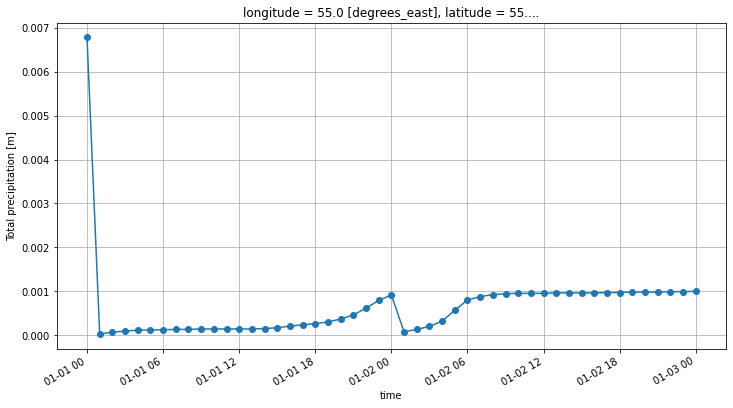

In [221]:
# look at the data: plot
plt.figure(figsize=(12, 6))
cut['tp'].plot.line(x='time', marker='o')
plt.grid(True)


In [228]:
''' you see that the precip accumulates and then resets in the end of each day, but what time does that happen - the max is in midnight'''

print('max precip time:', cutdf.tp.idxmax())


max precip time 2020-01-01 00:00:00


In [229]:
''' we have to shift the precipitation one "step" back, so that max value occurs at 23:00, so that it is the same day '''

shifted = cut.shift(time= -1, fill_value=0)

In [230]:
''' calculate the differences per hour within each day using shifted data ''' 

# Create a sample xarray dataset for a year of data
data = shifted

# Function to calculate hourly differences with reset at midnight
def calculate_hourly_diff(arr):
    diff = np.diff(arr, prepend=0)
    return xr.DataArray(diff, coords=arr.coords)

# Calculate hourly differences with reset at midnight for the entire time series
hourly_values = shifted.tp.groupby('time.dayofyear').apply(calculate_hourly_diff)

# Create a new dataset with the hourly differences
hourly_data = xr.Dataset({'hourly_values': hourly_values})


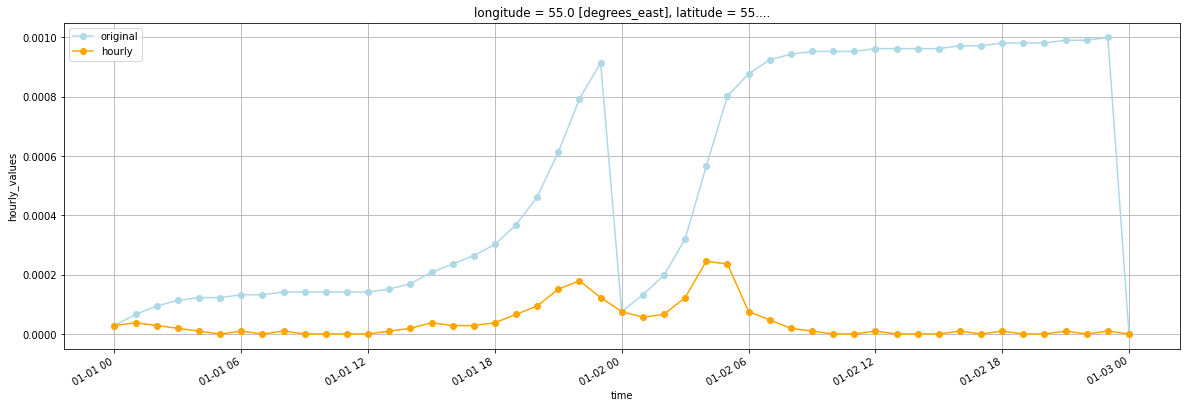

In [233]:
''' plot to see if its correct '''
plt.figure(figsize=(20, 6))
shifted['tp'].plot.line(x='time', marker='o', color ='lightblue', label ='original')
hourly_data['hourly_values'].plot.line(x='time', marker='o', color ='orange', label = 'hourly')

plt.grid()
plt.legend()

In [243]:
''' calculate the sum within day in a shifted data, compare with the max within the same day in the original data '''

# slice data - take a day  
start_date = '2020-01-01T00:00:00.000000000'
end_date = '2020-01-01T23:00:00.000000000'

# Slice the dataset for a day 
cut_sh = shifted.sel(time=slice(start_date, end_date))
cut_hourl = hourly_data.sel(time=slice(start_date, end_date))

print('new hourly data - daily sum:', round(cut_hourl.hourly_values.values.sum(), 6))
print('original data - daily max (cumulative sum):', round(cut_sh.tp.values.max(), 6))

''' correct! '''

new hourly data - daily sum: 0.000915
original data - daily max (cumulative sum): 0.000915


' correct! '

In [244]:
''' since we shifted data, the last data point doesnt make sense anymore - cut it out''' 
hourly_diff_data = hourly_diff_data.isel(time=slice(None, -1))


# hourly_diff_data - is the final dataset!! 